# **IPL FORECASTING ALL SEASON DETAILS-FINAL NOTEBOOK**

#### **Time-Series Analysis and Forecasting Workflow.**
1. Data Preparation
2. Data Visualization
3. Outlier Detection
4. Feature Engineering
5. Stationarity Check
6. Model Selection
5. Forecasting

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
# Normalize the runs for better performance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


# Read the CSV file into a DataFrame
data = pd.read_csv("/content/sample_data/updated_all_season_details.csv", low_memory=False)
import warnings
warnings.filterwarnings("ignore")

In [3]:
hardik_data = data[data['batsman1_name'] == 'Hardik Pandya']

In [4]:
hardik_season_runs = hardik_data.groupby('season')['runs'].sum()

In [5]:
if isinstance(hardik_season_runs, pd.Series):
    hardik_season_runs = hardik_season_runs.reset_index()

In [6]:
hardik_season_runs['season'] = pd.to_datetime(hardik_season_runs['season'], format='%Y')
print(hardik_season_runs)

      season  runs
0 2015-01-01   114
1 2016-01-01    55
2 2017-01-01   257
3 2018-01-01   275
4 2019-01-01   426
5 2020-01-01   283
6 2021-01-01   132
7 2022-01-01   511
8 2023-01-01   344


In [7]:
print(hardik_season_runs.columns)

Index(['season', 'runs'], dtype='object')


## **VISUALIZATION**

In [8]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

In [10]:
data.columns

Index(['season', 'match_id', 'match_name', 'home_team', 'away_team',
       'current_innings', 'innings_id', 'over', 'ball', 'runs', 'isBoundary',
       'isWide', 'isNoball', 'batsman1_id', 'batsman1_name', 'batsman1_runs',
       'batsman1_balls', 'bowler1_id', 'bowler1_name', 'bowler1_overs',
       'bowler1_maidens', 'bowler1_runs', 'bowler1_wkts', 'batsman2_id',
       'batsman2_name', 'batsman2_runs', 'batsman2_balls', 'bowler2_id',
       'bowler2_name', 'bowler2_overs', 'bowler2_maidens', 'bowler2_runs',
       'bowler2_wkts', 'wicket_id', 'wkt_batsman_name', 'wkt_bowler_name',
       'wkt_batsman_runs', 'wkt_batsman_balls', 'wkt_text', 'isRetiredHurt'],
      dtype='object')

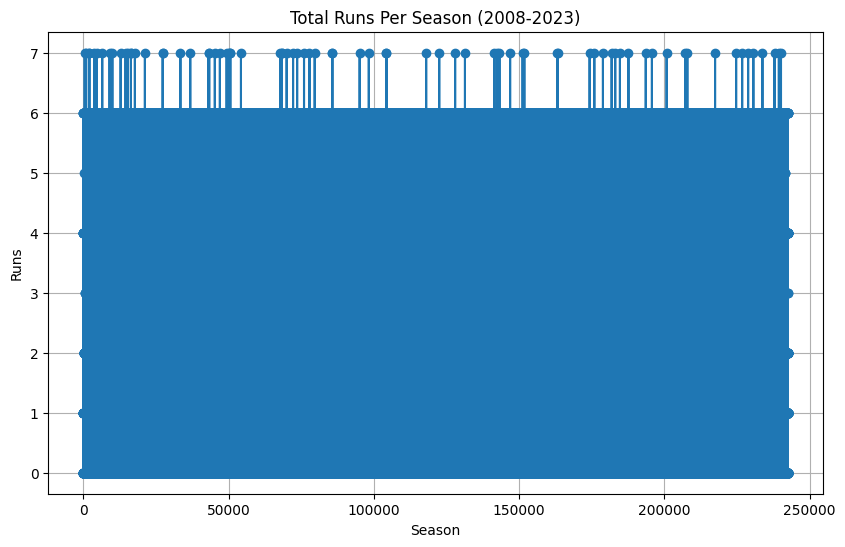

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data['runs'], marker='o')
plt.title("Total Runs Per Season (2008-2023)")
plt.xlabel("Season")
plt.ylabel("Runs")
plt.grid()
plt.show()

## **Outlier Detection**

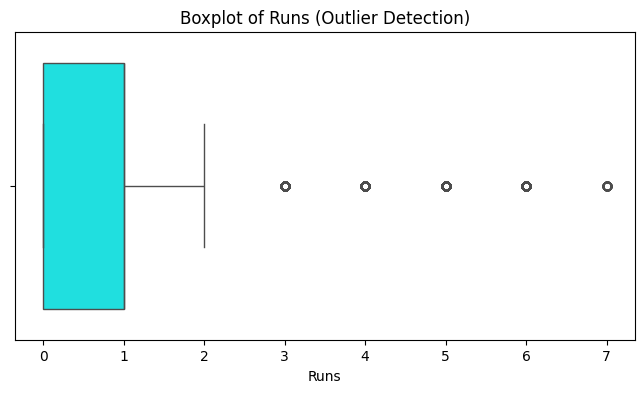

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['runs'], color='cyan')
plt.title("Boxplot of Runs (Outlier Detection)")
plt.xlabel("Runs")
plt.show()

**No specific outlier value in the runs**

In [14]:
import plotly.express as px

In [16]:
fig = px.histogram(
    data,
    x='runs',
    nbins=10,  # Number of bins
    color_discrete_sequence=['purple'],  # Set color
    marginal="box",  # Add a box plot for better insights
    title="Interactive Distribution of Runs",
)

# Add KDE curve
fig.update_traces(opacity=0.75, marker_line_width=1.5)
fig.update_layout(
    xaxis_title="Runs",
    yaxis_title="Frequency",
    template="plotly_white"
)

# Show the figure
fig.show()

## **Feature Engineering**

### **Lag Feature**

In [17]:
data['Lag_1'] = data['runs'].shift(1)
data['Lag_2'] = data['runs'].shift(2)

### **Time-based Features**

In [18]:
data.index = pd.to_datetime(data.index)

In [19]:
data['Month'] = data.index.month
data['Year'] = data.index.year

## **Stationary Check**

In [20]:
print(hardik_season_runs.columns)

Index(['season', 'runs'], dtype='object')


### **Autocorrelation and Partial Autocorrelation Plots**

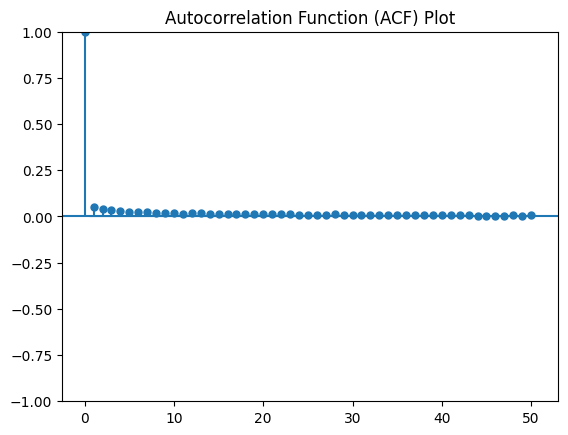

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['runs'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

**Stationarity:**

A rapid decay like this is an indicator of stationarity in the series. Stationary time series have constant mean and variance over time, and their autocorrelation quickly diminishes.

**Partial Autocorrelation Function (PACF) Plot**

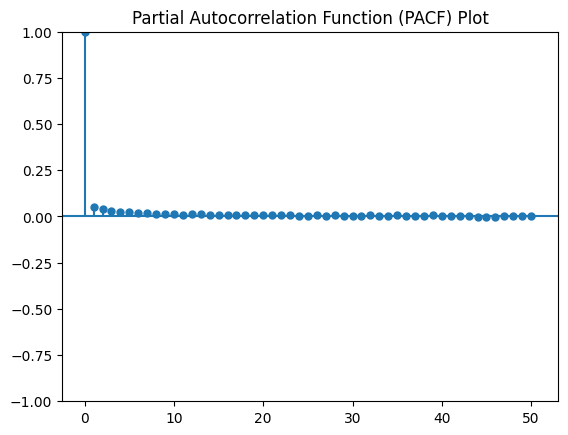

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data['runs'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

**Augmented Dickey-Fuller (ADF) Test**

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['runs'].dropna())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -64.687619
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


**Null Hypothesis (H₀)**: The series is non-stationary.

**Since the p-value is 0.000000 (which is much less than 0.05), we reject the null hypothesis and conclude that the time series is stationary.**

In [ ]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(data['runs'].dropna(), regression='c')
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")

KPSS Statistic: 7.4795123845417555
p-value: 0.01


**Interpretation of Results:**

**KPSS Statistic:** A higher value indicates stronger evidence against the null hypothesis.

**p-value:** Since the p-value (0.01) is less than 0.05, we reject the null hypothesis. This suggests that the series is non-stationary.

## **Transformation to Achieve Stationarity**

### **Differencing**


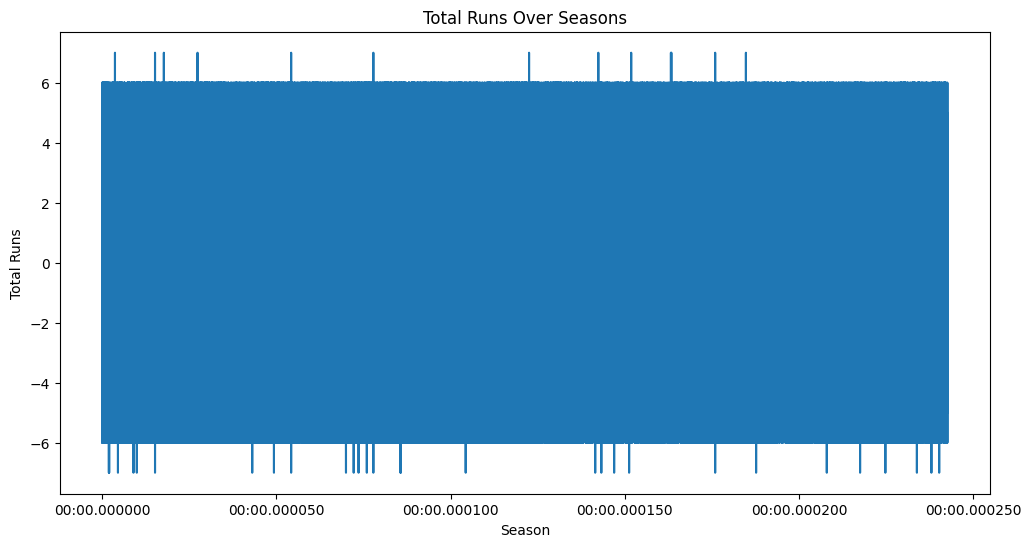

In [ ]:
data['diff_runs'] = data['runs'] - data['runs'].shift(1)

plt.figure(figsize=(12, 6))
plt.plot(data['diff_runs'])
plt.title('Total Runs Over Seasons')
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.show()


The graph represents the first-order differenced series:
diff_runs
=
runs
𝑡
−
runs
𝑡
−
1
diff_runs=runs
t
​
 −runs
t−1
​
 .

Differencing is applied to remove trends or seasonality, making the series stationary

### **ADF After Transformation result**

In [ ]:
adf_result_diff = adfuller(data['diff_runs'].dropna())
print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -89.229394
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


**Null Hypothesis (H₀):**

The null hypothesis of the ADF test states that the series is non-stationary (i.e., it has a unit root).

The **ADF statistic (-89.229394)** is much smaller than the critical values at all confidence levels (1%, 5%, and 10%).
This suggests that the null hypothesis can be rejected.
p-value:

The **p-value** is 0.000000 (essentially zero), which is much smaller than the standard threshold (0.05).
This also strongly indicates that the null hypothesis can be rejected.

## **Log Transformation**

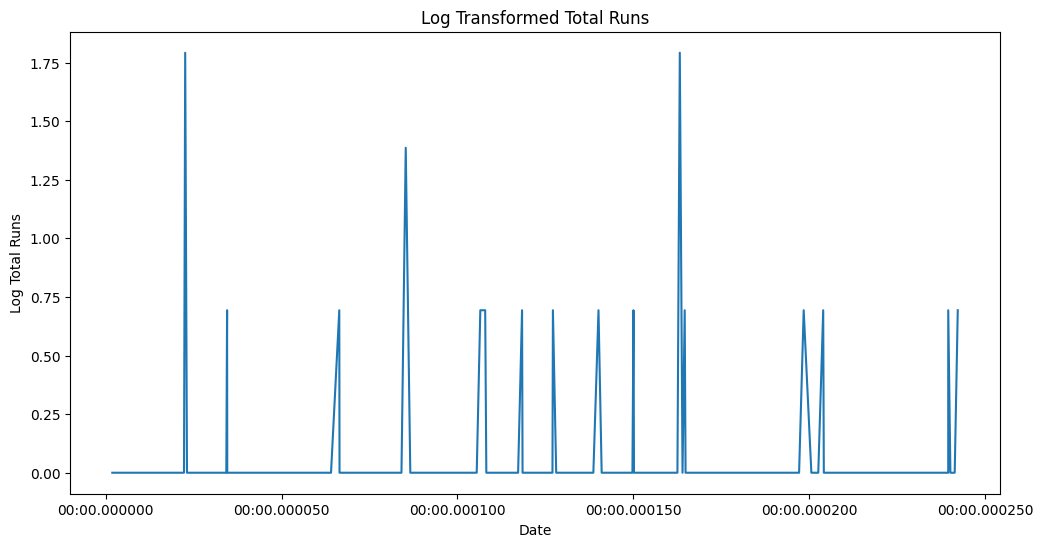

In [ ]:
#data['Log_Total_Runs'] = np.log(data['runs'])
data['Log_Total_Runs'] = np.log(data['runs']).replace([np.inf, -np.inf], np.nan)
data['Log_Diff_1'] = data['Log_Total_Runs'] - data['Log_Total_Runs'].shift(1)
data['Log_Diff_1'].dropna(inplace=True)
data.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(data['Log_Total_Runs'])
plt.title('Log Transformed Total Runs')
plt.xlabel('Date')
plt.ylabel('Log Total Runs')
plt.show()

In [ ]:
adf_result_log_diff = adfuller(data['Log_Diff_1'])
print('ADF Statistic: %f' % adf_result_log_diff[0])
print('p-value: %f' % adf_result_log_diff[1])
print('Critical Values:')
for key, value in adf_result_log_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.615309
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


**Null Hypothesis (H₀):**

The null hypothesis states that the series is non-stationary (i.e., it contains a unit root).

The **ADF Statistic** (-15.615309) is much smaller than the critical values at all levels (1%, 5%, 10%).
This indicates that the null hypothesis can be rejected with strong confidence.
p-value:

The **p-value** is 0.000000, which is far below the typical threshold of 0.05.
This strongly supports rejecting the null hypothesis.

## **Re-Checking ACF and PACF Plots**

### **ACF Plot of Differenced Series**

<Figure size 1000x600 with 0 Axes>

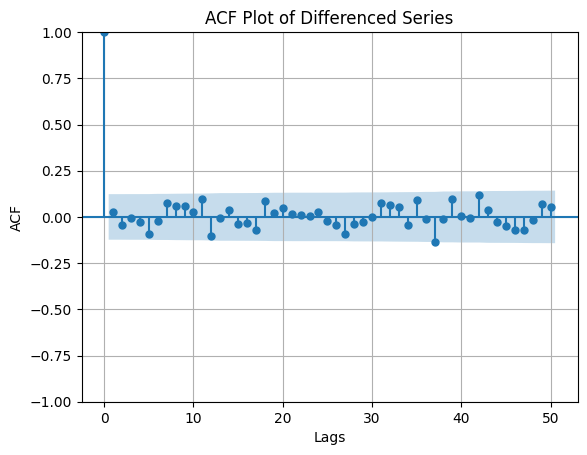

In [ ]:
# ACF plot for differenced series
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(data['diff_runs'].dropna(), lags=50)
plt.title('ACF Plot of Differenced Series')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

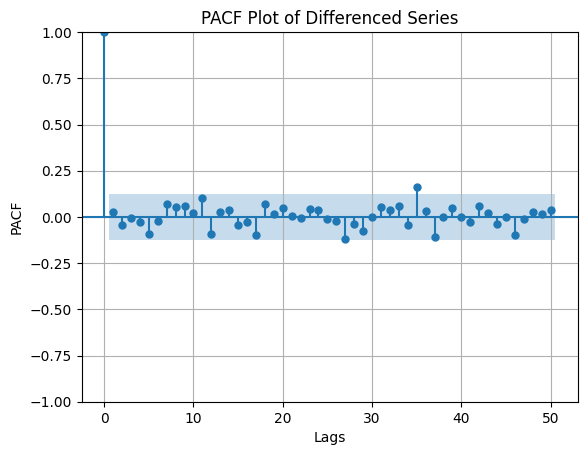

In [ ]:
# PACF plot for differenced series
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10, 6))
plot_pacf(data['diff_runs'].dropna(), lags=50)
plt.title('PACF Plot of Differenced Series')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()


**Interpretation and Observations**

**Differenced Series:**

If the ACF plot drops off quickly after a few lags, it suggests that the differenced series is stationary.

The PACF plot should show significant spikes at early lags and then decay, indicating potential autoregressive components.

## **Forecast Using SARIMAX**

In [22]:
print(hardik_season_runs.columns)

Index(['season', 'runs'], dtype='object')


In [23]:
hardik_season_runs.set_index('season', inplace=True)

In [24]:
num_seasons = len(hardik_season_runs)
num_seasons

9

In [25]:
print(hardik_season_runs.dtypes)


runs    int64
dtype: object


In [52]:
model = SARIMAX(hardik_season_runs,
                order=(1, 1, 1),  # p, d, q - non seasonal parameters
                seasonal_order=(1, 1, 1, 4
                                ))  # P, D, Q, m  - seasonal parameters

In [27]:
result = model.fit()
result

In [28]:
forecast = result.get_forecast(steps=5)  # Forecast for the next season
forecast_runs = forecast.predicted_mean.astype(int)
print(f"Predicted runs for next season: {forecast_runs}")

Predicted runs for next season: 2024-01-01    286
2025-01-01    485
2026-01-01    506
2027-01-01    654
2028-01-01    512
Freq: YS-JAN, Name: predicted_mean, dtype: int64


In [59]:
# Create a DataFrame for the forecasted results
forecast_df = pd.DataFrame({
    'season': forecast.predicted_mean.index,  # Use the index (date range) for the seasons
    'predicted_runs': forecast_runs.values
})

In [60]:
forecast_df

,season,predicted_runs
0,2024-01-01,286.564137


In [30]:
import plotly.graph_objects as go

In [61]:
# Create traces for actual and predicted runs
#forecast_df = pd.DataFrame({'season': pd.date_range(start='2023-01-01', periods=5, freq='YS'), 'predicted_runs': forecast_runs.values})
trace_actual = go.Scatter(
    x=hardik_season_runs.index,
    y=hardik_season_runs['runs'],
    mode='lines',
    name='Actual Runs',
    line=dict(color='blue')
)

trace_predicted = go.Scatter(
    x=forecast_df['season'],
    y=forecast_df['predicted_runs'],
    mode='lines+markers',
    name='Predicted Runs',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='circle', size=6)
)

# Create layout for the plot
layout = go.Layout(
    title='Hardik Pandya Season Runs: Actual vs. Predicted',
    xaxis=dict(title='Season'),
    yaxis=dict(title='Total Runs'),
    showlegend=True
)

# Create the figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)

# Show the interactive plot
fig.show()


 **Interpretation:**

The forecast suggests that **Hardik Pandya's performance might peak around 2024–2025** and could experience a decline afterward.

The model has extrapolated this prediction based on historical trends and stationarity properties of the dataset.

In [40]:
import pickle

In [62]:
with open('ipl_forecasting.pkl', 'wb') as f:
    pickle.dump(result, f)

In [63]:
from google.colab import files

In [64]:
files.download('ipl_forecasting.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>